<a href="https://colab.research.google.com/github/krooner/data-analysis-projects/blob/main/02_predictive_modeling_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 결측치 보간법과 랜덤포레스트로 따릉이 데이터 예측하기
---
1시간 전의 기상 정보를 활용하여 **해당 시간의 따릉이 대여 수를 예측하기**

## 1. Import libraries

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt
import seaborn as sns

plt.rc('axes', unicode_minus=False) # 마이너스 기호 출력

import warnings
warnings.filterwarnings('ignore')

## 2. Download dataset

In [2]:
!wget 'https://bit.ly/3gLj0Q6'

import zipfile
with zipfile.ZipFile('3gLj0Q6', 'r') as existing_zip:
    existing_zip.extractall('data')

--2022-05-22 03:18:02--  https://bit.ly/3gLj0Q6
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E [following]
--2022-05-22 03:18:03--  https://drive.google.com/uc?export=download&id=1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E
Resolving drive.google.com (drive.google.com)... 173.194.216.100, 173.194.216.113, 173.194.216.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.216.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ripsk6biu5bjeknm4bfh0nt1h53bcc0b/1653189450000/17946651057176172524/*/1or_QN1ksv81DNog6Tu_kWcZ5jJWf5W9E?e=download [following]
--2022-05-22 03:18:03--  https://doc-0c-10-docs.googleusercontent.com/docs/securesc/ha0r

## 3. Load file

In [11]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

## 4. EDA

### `train`
피쳐 종류는 다음과 같다.

||id|hour|temp|prec|wind|humidity|visibility|ozone|pm10|pm2.5|count|
|---|---|---|---|---|---|---|---|---|---|---|---| 
||ID|시간|기온|강수 여부|풍속|습도|가시성|오존|미세먼지|초미세먼지|대여 수 (종속 변수)|

피쳐가 모두 수치형 데이터이다. 
- **수치형 데이터 간의 상관관계** 분석을 통해 필요없는 피쳐는 제외한다.

결측치가 존재한다.
- 결측치를 어떻게 대체할 것인가?

In [ ]:
print(train.info())
print()
# print(train.isnull().sum())
# print()
print(train.describe())
print()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
None

                id         hour  hour_bef_temperature  hour_bef_precipitation  \
count  1459.000000  1459.000000           1457.000000            

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


### 시각화
`count`에 대한 히스토그램

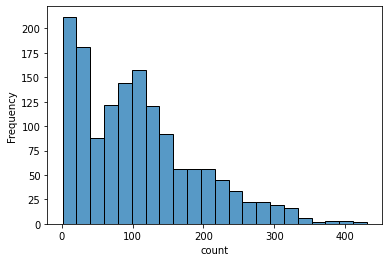

In [ ]:
sns.histplot(train['count'])
plt.ylabel("Frequency")
plt.show()

### 전체 수치형 변수 간의 상관관계 시각화
- `id`는 무의미한 피쳐다.
- `강수량, 미세먼지, 초미세먼지`는 비교적 `count`와의 상관관계의 정도가 낮다.

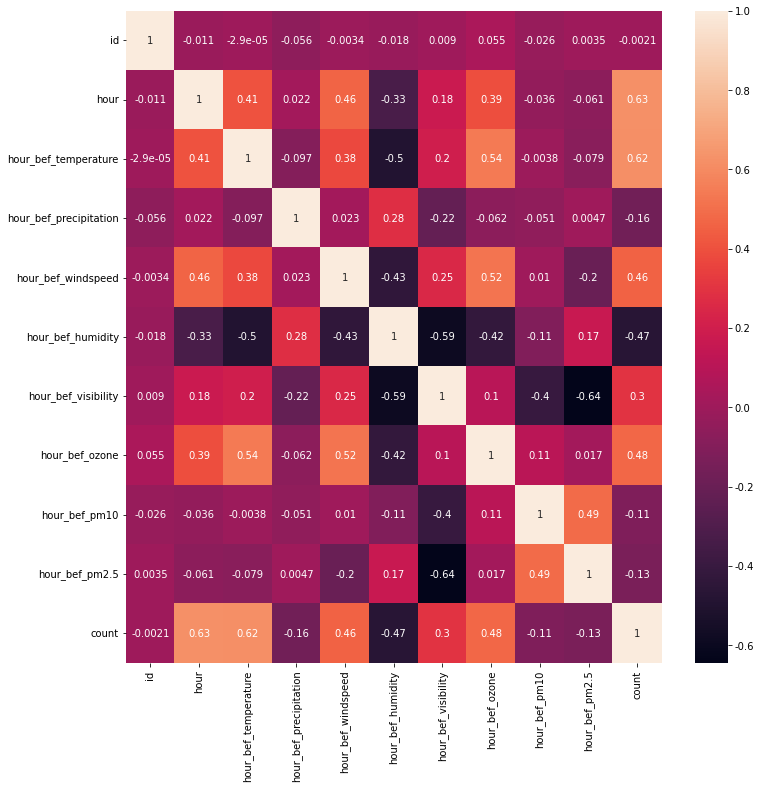

In [ ]:
plt.figure(figsize = (12, 12))
sns.heatmap(train.corr(), annot = True)

### `test`
피쳐 종류는 `count`를 제외하고 동일하며, 역시 결측치가 존재한다.

In [ ]:
print(test.info())
print()
# print(test.isnull().sum())
# print()
print(test.describe())
print()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB
None

                id        hour  hour_bef_temperature  hour_bef_precipitation  \
count   715.000000  715.000000            714.000000              714.000000   
mean   1056.854545   11.472727            

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


## 5. 전처리
결측치를 어떻게 처리할 것인가? 

변수들의 상관관계를 고려할 필요가 있다.

변수 `A`에 결측치가 있고, 변수 `A, B`의 상관관계가 높은 경우 Regression으로 결측치를 대체할 수 있을 것이다.

`train`에서 결측이 존재하는 컬럼: 
- `hour_bef_temperature` - 온도
- `hour_bef_precipitation` - 강수량
- `hour_bef_windspeed` - 풍속
- `hour_bef_humidity` - 습도
- `hour_bef_visibility` - 가시성
- `hour_bef_ozone` - 오존
- `hour_bef_pm10` - 미세먼지
- `hour_bef_pm2.5` - 초미세먼지

---

- ~~`train` 에서 결측치를 포함한 row는 제거하고 `test`의 결측치는 0으로 대체하기.~~

- ~~보간법으로 채우기. `.interpolate`~~
  - 시간 순으로 정렬되어 있지 않다 (Unordered)

- **결측치의 컬럼 평균 값으로 대체하기.**

In [12]:
# train = train.dropna()
# test = test.fillna(0)

# train.interpolate(inplace = True)
# test.interpolate(inplace = True)

train.fillna(train.mean(), inplace = True)
test.fillna(test.mean(), inplace = True)

print(train.isnull().sum())
print(test.isnull().sum())

X_train = train.drop(['count', 'id', 'hour_bef_pm10', 'hour_bef_pm2.5'], axis = 1)
# X_train = train.drop(['id', 'count'], axis = 1)
Y_train = train['count']

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64
id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
dtype: int64


## 6. 모델링

1. `분류`가 아닌 `대여 횟수`를 추정해야하기 때문에 ~~`DecisionTreeClassifier()`~~ `DecisionTreeRegressor()`를 선언한다.
2. 모델을 학습시킨다.
3. 모델을 평가한다.

In [13]:
model = RandomForestRegressor()
model.fit(X_train, Y_train)

test = test.drop(['id', 'hour_bef_pm10', 'hour_bef_pm2.5'], axis = 1)
# test = test.drop(['id'], axis = 1)
pred = model.predict(test)

## 7. 결과 저장

In [14]:
df = pd.read_csv("data/submission.csv")
df['count'] = pred
df.to_csv("submission_rf_fill_mean_remove_dust.csv", index = False)

## 8. 하이퍼파라미터 튜닝
GridSearch
- 검색할 Parameter candidates를 정한다.
- 모델, 파라미터, 목적 함수 (MSE), Fold (3)를 설정한다.

In [18]:
param = {
    'min_samples_split': [30, 50, 70, 90],
    'max_depth': [5, 6, 7],
    'n_estimators': [50, 150, 250, 300]
}

gs = GridSearchCV(
    estimator = model, 
    param_grid = param, 
    scoring = 'neg_mean_squared_error', 
    cv = 3)

gs.fit(X_train, Y_train)

pred_gs = gs.predict(test)

## 결과 저장

In [19]:
df = pd.read_csv("data/submission.csv")
df['count'] = pred_gs
df.to_csv("submission_rf_fill_mean_remove_dust_grid.csv", index = False)